# Brain Tumor Detection - Enhanced Implementation
This notebook implements an enhanced approach to brain tumor detection using advanced feature extraction and ensemble methods.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import os
import cv2
from tqdm import tqdm
import warnings
from scipy import stats
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.filters import gabor
import pywt
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)

In [3]:
# Define paths and parameters
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(BASE_DIR, 'kaggle_3m')
IMAGE_SIZE = 224

print(f"Base directory: {BASE_DIR}")
print(f"Data path: {DATA_PATH}")
print(f"Directory exists: {os.path.exists(DATA_PATH)}")

Base directory: c:\Users\varsh\Downloads\Compressed\Brain Tumor Detector
Data path: c:\Users\varsh\Downloads\Compressed\Brain Tumor Detector\kaggle_3m
Directory exists: True


In [4]:
# Enhanced preprocessing
def preprocess_image(img):
    # Convert to grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    
    # Apply non-local means denoising
    img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
    
    # Resize image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    
    return img

In [5]:
# Enhanced feature extraction
def extract_features(image_path):
    try:
        # Read and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            return None
        
        img = preprocess_image(img)
        features = []
        
        # 1. Basic Intensity Features
        features.extend([
            np.mean(img),
            np.std(img),
            np.median(img),
            stats.kurtosis(img.flatten()),
            stats.skew(img.flatten())
        ])
        
        # 2. Edge Features
        edges = cv2.Canny(img, 100, 200)
        features.append(np.sum(edges) / (IMAGE_SIZE * IMAGE_SIZE))
        
        # 3. Texture Features
        img_uint8 = (img * 255).astype(np.uint8)
        glcm = graycomatrix(img_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        features.extend([
            graycoprops(glcm, 'contrast')[0, 0],
            graycoprops(glcm, 'correlation')[0, 0],
            graycoprops(glcm, 'energy')[0, 0],
            graycoprops(glcm, 'homogeneity')[0, 0]
        ])
        
        # 4. LBP Features
        lbp = local_binary_pattern(img, 8, 1, method='uniform')
        features.extend([
            np.mean(lbp),
            np.std(lbp),
            np.median(lbp)
        ])
        
        # 5. Gabor Features
        for theta in range(4):
            theta = theta / 4. * np.pi
            for sigma in (1, 3):
                for frequency in (0.05, 0.25):
                    filt_real, filt_imag = gabor(img, frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)
                    features.extend([
                        np.mean(filt_real),
                        np.std(filt_real)
                    ])
        
        # 6. Wavelet Features
        coeffs = pywt.dwt2(img, 'haar')
        cA, (cH, cV, cD) = coeffs
        features.extend([
            np.mean(cA),
            np.std(cA),
            np.mean(cH),
            np.std(cH),
            np.mean(cV),
            np.std(cV),
            np.mean(cD),
            np.std(cD)
        ])
        
        return features
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

In [6]:
# Load and preprocess data
def load_data():
    features = []
    labels = []
    
    # Get all patient directories
    patient_dirs = [d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))]
    print(f"Found {len(patient_dirs)} patient directories")
    
    for patient_dir in tqdm(patient_dirs, desc="Processing patients"):
        patient_path = os.path.join(DATA_PATH, patient_dir)
        
        # Get all image files (excluding masks)
        image_files = [f for f in os.listdir(patient_path) 
                      if f.endswith('.tif') and not f.endswith('_mask.tif')]
        
        for img_file in image_files:
            img_path = os.path.join(patient_path, img_file)
            mask_path = os.path.join(patient_path, img_file.replace('.tif', '_mask.tif'))
            
            # Check if mask exists and has tumor pixels
            has_tumor = False
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                if mask is not None and np.any(mask > 0):
                    has_tumor = True
            
            # Extract features
            img_features = extract_features(img_path)
            if img_features is not None:
                features.append(img_features)
                labels.append(1 if has_tumor else 0)
    
    features = np.array(features)
    labels = np.array(labels)
    
    # Print class distribution
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nClass distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"Class {label}: {count} samples")
    
    return features, labels

In [7]:
# Load the data
X, y = load_data()
print(f"Shape of features: {X.shape}")
print(f"Shape of labels: {y.shape}")
print(f"Number of tumor cases: {np.sum(y)}")
print(f"Number of non-tumor cases: {len(y) - np.sum(y)}")

Found 110 patient directories


Processing patients: 100%|██████████| 110/110 [19:20<00:00, 10.55s/it]


Class distribution:
Class 0: 2556 samples
Class 1: 1373 samples
Shape of features: (3929, 53)
Shape of labels: (3929,)
Number of tumor cases: 1373
Number of non-tumor cases: 2556


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Train and evaluate Logistic Regression (baseline)
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)
lr_predictions = lr_model.predict(X_test_scaled)
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Linear Regression Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_predictions))

Linear Regression Accuracy: 0.7684

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       511
           1       0.64      0.76      0.70       275

    accuracy                           0.77       786
   macro avg       0.75      0.77      0.76       786
weighted avg       0.78      0.77      0.77       786



In [10]:
# Feature selection
selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median'
)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Selected number of features: {X_train_selected.shape[1]}")

Original number of features: 53
Selected number of features: 27


In [11]:
# Create base models for stacking
rf1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf2 = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='log2',
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Create stacking ensemble
stacking = StackingClassifier(
    estimators=[
        ('rf1', rf1),
        ('rf2', rf2)
    ],
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    cv=5,
    n_jobs=-1
)

# Train and evaluate stacking ensemble
print("Training stacking ensemble...")
stacking.fit(X_train_selected, y_train)

stacking_predictions = stacking.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, stacking_predictions)
print(f"Stacking Ensemble Accuracy: {stacking_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, stacking_predictions))

Training stacking ensemble...
Stacking Ensemble Accuracy: 0.8575

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       511
           1       0.78      0.83      0.80       275

    accuracy                           0.86       786
   macro avg       0.84      0.85      0.85       786
weighted avg       0.86      0.86      0.86       786



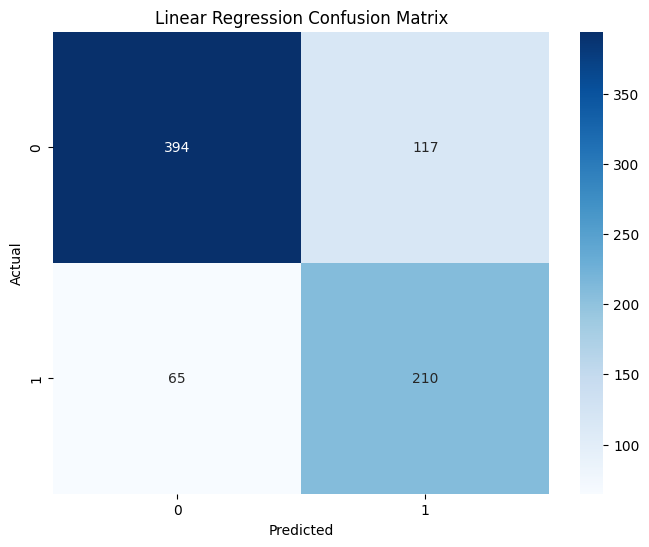

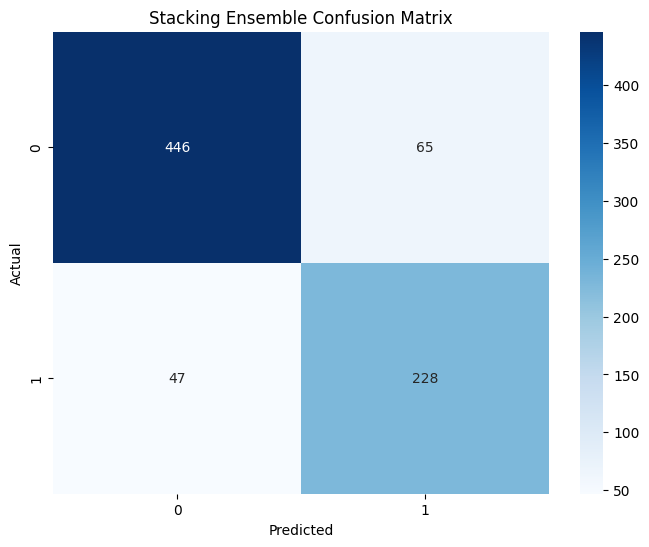

In [12]:
# Plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, lr_predictions, 'Linear Regression Confusion Matrix')
plot_confusion_matrix(y_test, stacking_predictions, 'Stacking Ensemble Confusion Matrix')

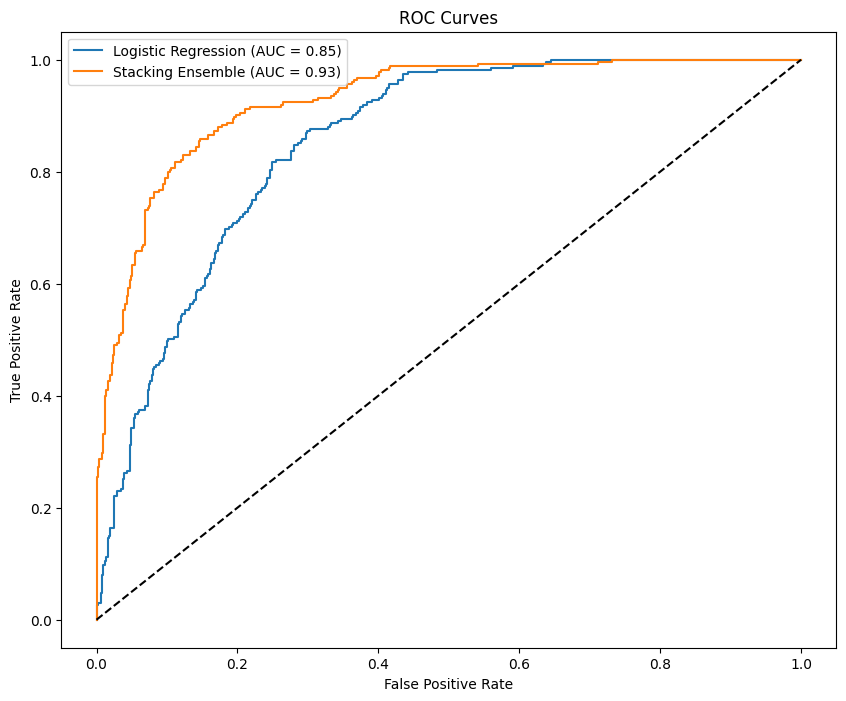

In [13]:
# Plot ROC curves
def plot_roc_curve(y_true, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(y_test, lr_model.predict_proba(X_test_scaled)[:, 1], 'Logistic Regression')
plot_roc_curve(y_test, stacking.predict_proba(X_test_selected)[:, 1], 'Stacking Ensemble')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [2]:
# Feature importance from the first Random Forest
feature_names = [
    'Mean', 'Std', 'Median', 'Kurtosis', 'Skewness',  # Intensity
    'Edge Density',  # Edge
    'Contrast', 'Correlation', 'Energy', 'Homogeneity',  # Texture
    'LBP Mean', 'LBP Std', 'LBP Median',  # LBP
    'Gabor Mean 1', 'Gabor Std 1',  # Gabor
    'Wavelet Mean A', 'Wavelet Std A',  # Wavelet
    'Wavelet Mean H', 'Wavelet Std H',
    'Wavelet Mean V', 'Wavelet Std V',
    'Wavelet Mean D', 'Wavelet Std D'
]

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': stacking.named_estimators_['rf1'].feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.show()

NameError: name 'pd' is not defined

In [1]:
# Model comparison
models = ['Logistic Regression', 'Stacking Ensemble']
accuracies = [lr_accuracy, stacking_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

NameError: name 'lr_accuracy' is not defined